# Unsupervised Learning - Density Estimation

In this exercise we will be looking at how histograms may be deceiving and how to use different density estimations.

In terms of code, using any clustering method is the same in sklearn so we will just run the clustering comparison demo for you to see where the density-based clustering methods can be more effective.

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
import math

plt.style.use("ggplot")
np.random.seed(0)

In [0]:
from sklearn.neighbors import KernelDensity

In [0]:
mu_1, sigma_1, n_1 = 0, 0.5, 1000
mu_2, sigma_2, n_2 = 2, 1, 500

vals_1 = np.random.normal(mu_1, sigma_1, n_1)
vals_2 = np.random.normal(mu_2, sigma_2, n_2)

In [0]:
vals = np.concatenate((vals_1, vals_2), axis=0)
n = vals.shape[0]
sigma = vals.std()

We've generated some data and now we want to plot a histogram of the data. Next we will select `10` as an arbitrary number of bins.

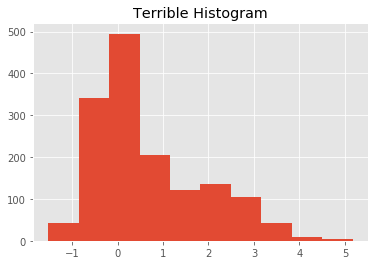

In [65]:
plt.hist(vals, 10)
plt.title("Terrible Histogram")
plt.show()

In [66]:
n, sigma

(1500, 1.1867781420819472)

We can calculate the number of bins, $b$, from the bin width, $w$, as
$$
b = \frac{max - min}{w}.
$$

In [0]:
def bin_count(max_val, min_val, width):
    """Return the number of bins for a histogram
    
    Args:
        max_val (float): The maximum value in the dataset
        min_val (float): The minimum value in the dataset
        width (float): The bin width
    
    Returns:
        int: The number of bins for the histogram
    """
    b = int(np.ceil((max_val - min_val)/width))
    return b

In [0]:
assert bin_count(500, 100, 20) == 20
assert bin_count(600, 100, 25) == 20
assert bin_count(500, 100, 18) == 23
assert isinstance(bin_count(500, 100, 20), int)

Now let's select a better number of bins by using Scott's rule and Freedman & Diaconis' rule.

In [0]:
def scotts_rule_count(data):
    """Calculate the number of bins using Scott's rule
    
    Args:
        data (np.ndarray): The data array
    
    Returns:
        int: The number of bins of the histogram
    """
    # YOUR CODE HERE
    sigma = np.std(data)
    n_samples = len(data)
    width = 3.49 * sigma * n_samples ** (-1/3)
    min_val = np.amin(data)
    max_val = np.amax(data)
    scotts_rule = bin_count(max_val, min_val, width)
    
    return scotts_rule

In [0]:
test_data = np.random.normal(0,1,500)
test_data_2 = np.random.uniform(0,5,500)
assert isinstance(scotts_rule_count(np.random.normal(0,1,500)), int)
assert scotts_rule_count(test_data) in (13,14,15)
assert scotts_rule_count(test_data_2) in (8,9,10)

Creating a histogram with 19 bins.


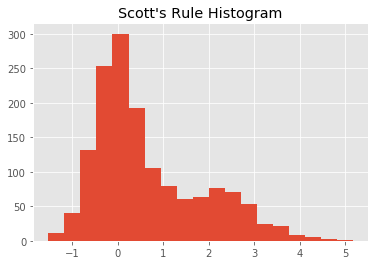

In [71]:
scott_bins = scotts_rule_count(vals)
print(f"Creating a histogram with {scott_bins} bins.")
plt.hist(vals, bins=scott_bins)
plt.title("Scott's Rule Histogram")
plt.show()

Now we'll try Freedman and Diaconis' rule. To calculate the interquartile range, you may want to look into calculating the percentiles using [np.percentile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html).

In [0]:
def fd_rule_count(data):
    """Calculate the number of bins using Freedman & Diaconis' rule
    
    Args:
        data (np.ndarray): The data array
    
    Returns:
        int: The number of bins for the histogram
    """
    dist = np.percentile(data, 75) - np.percentile(data, 25)
    n_samples = len(data)
    min_val = np.amin(data)
    max_val = np.amax(data)
    width = 2 * dist * n_samples ** (-1/3)
    freedman = bin_count(max_val, min_val, width)
    return freedman

In [0]:
assert fd_rule_count(test_data) in (15,16,17)
assert fd_rule_count(test_data_2) in (8,9,10)
assert isinstance(fd_rule_count(test_data), int)

Creating a histogram with 25 bins.


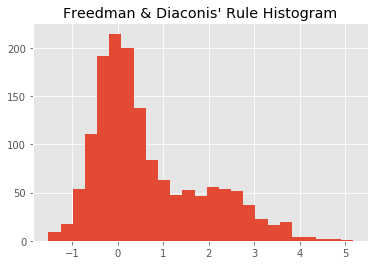

In [74]:
fd_bins = fd_rule_count(vals)
print(f"Creating a histogram with {fd_bins} bins.")
plt.hist(vals, bins=fd_bins)
plt.title("Freedman & Diaconis' Rule Histogram")
plt.show()

## Kernel Density Estimation

Let's add a density estimate to the plots.

In [0]:
def kernel_plotter(kernel, data, bins, bandwidth):
    plt.hist(data, bins=bins, density=True)
    X_plot = np.linspace(data.min(), data.max(), 1000)[:, np.newaxis]
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(data.reshape(-1, 1))
    log_dens = kde.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens))
    plt.title(f"Kernel = '{kernel}', h={bandwidth}")
    plt.show()

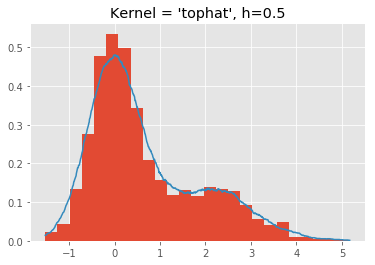

In [76]:
kernel_plotter("tophat", vals, fd_bins, 0.5)

The tophat, or uniform, kernel will look closest to the actual histogram with sufficient bins.

Now you will plot the various kernels with the same bandwidth value for the data we've been examining. Then you'll plot a variety of densities with the same kernel but different bandwidths. Try out different values and see what happens.

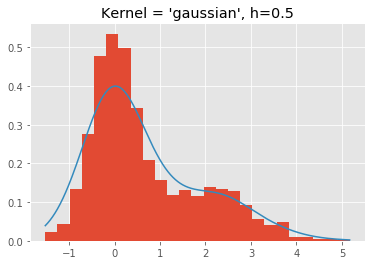

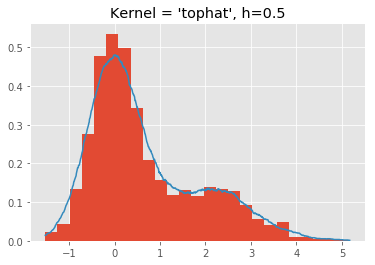

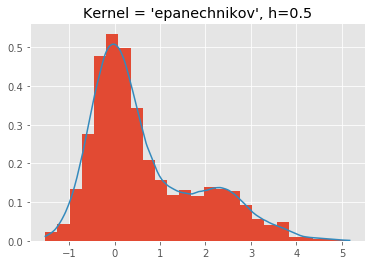

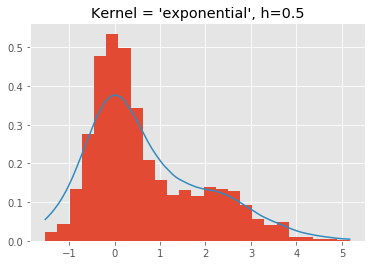

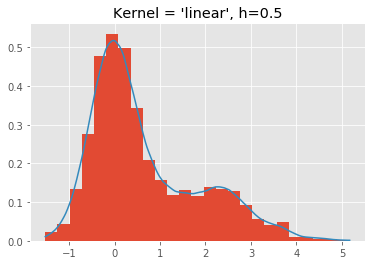

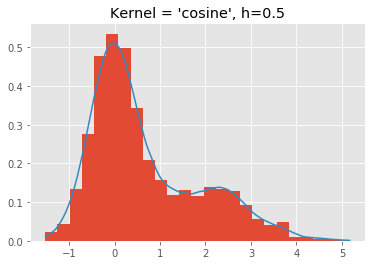

In [77]:
for kernel in ["gaussian","tophat","epanechnikov","exponential","linear","cosine"]:
    kernel_plotter(kernel, vals, fd_bins, 0.5)

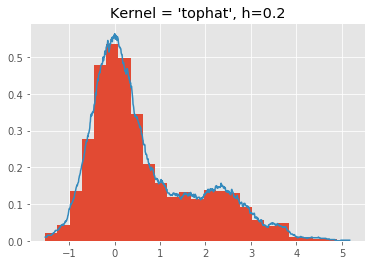

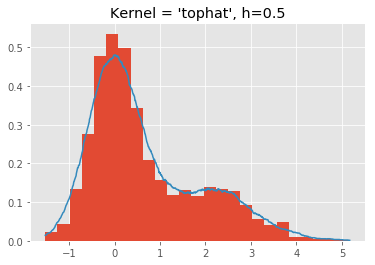

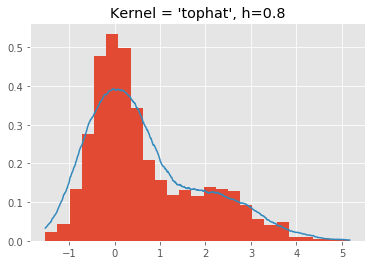

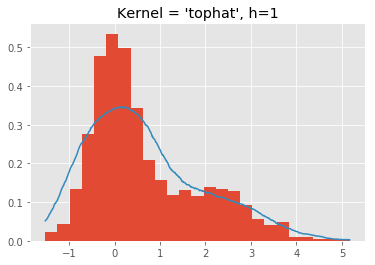

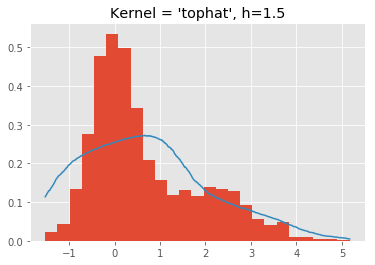

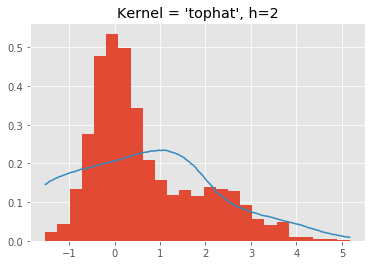

In [78]:
for bandwidth in [0.2, 0.5, 0.8, 1, 1.5, 2]:
    kernel_plotter("tophat", vals, fd_bins, bandwidth)

In [0]:
# Select what you think as the best kernel and best bandwidth
# Set them to best_kernel and best_bandwidth respectively
best_kernel = "epanechnikov"
best_bandwidth = 0.2

In [0]:
assert isinstance(best_kernel, str)
assert best_kernel in ["gaussian","tophat","epanechnikov","exponential","linear","cosine"]
assert isinstance(best_bandwidth, float)
assert best_bandwidth > 0
assert best_bandwidth <= 1

## Density-Based Clustering

Here's the clustering overview from the manifold clustering exercise again. Now the remaining clustering methods should make sense as well.

Please briefly read through the code again and see how we run clustering algorithms.

To summarize, with clustering methods we will,

- Instantiate the model hyperparameters ex: `model = MeanShift(bandwidth=bandwidth)`
- Determine clusters by using fit_predict, ex: `clutsers = model.fit_predict(features)`


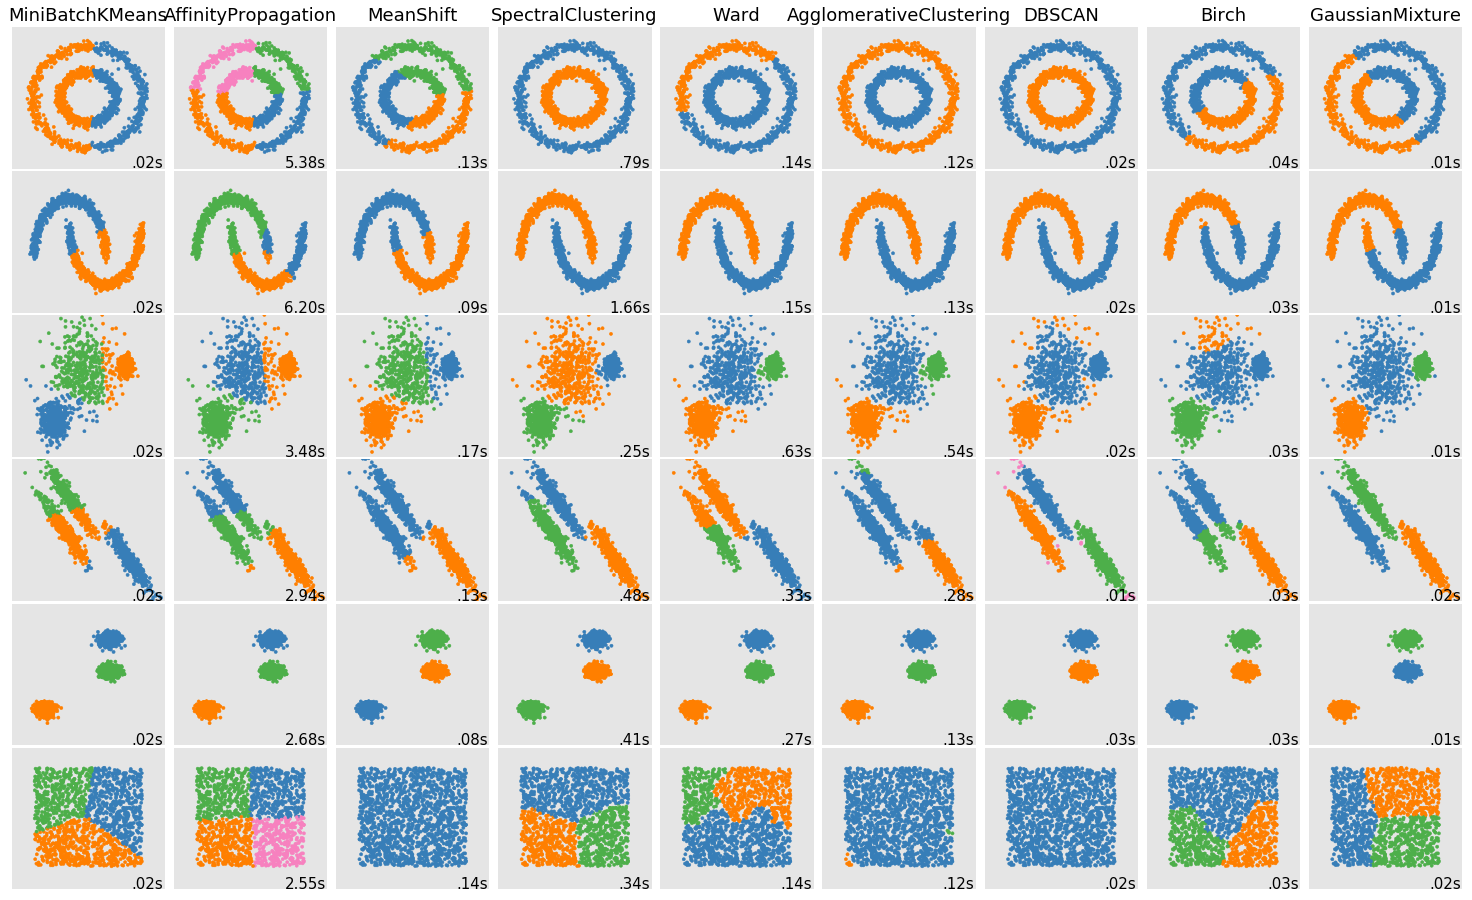

In [84]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

## Feedback

In [0]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    return "This was a good lab. I like that we got to test different kernels and see the effects. Random data made this a little harder though. What is a kernel?"